# Data_Transformation
This notebook handles:

Class Imbalance Analysis: Detailed visualization and statistics

Categorical Encoding: Label encoding + One-hot encoding

Feature Scaling: StandardScaler normalization

SMOTE Implementation: Balanced datasets with 30% fraud cases

Train-Test Split: Stratified splitting with proper data preparation

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [25]:

# Load feature-engineered data
fraud_data = pd.read_csv('fraud_data_with_features.csv')
creditcard_data = pd.read_csv('creditcard_data_with_features.csv')

print(f"Fraud data shape: {fraud_data.shape}")
print(f"Credit card data shape: {creditcard_data.shape}")

Fraud data shape: (129146, 45)
Credit card data shape: (283726, 31)


CLASS IMBALANCE ANALYSIS

In [3]:
# Analyze class distribution in both datasets
print("Class distribution in Fraud Data:")
fraud_class_dist = fraud_data['class'].value_counts()
print(fraud_class_dist)
print(f"Fraud rate: {fraud_class_dist[1] / len(fraud_data) * 100:.2f}%")

print("\nClass distribution in Credit Card Data:")
cc_class_dist = creditcard_data['Class'].value_counts()
print(cc_class_dist)
print(f"Fraud rate: {cc_class_dist[1] / len(creditcard_data) * 100:.2f}%")


Class distribution in Fraud Data:
0    116878
1     12268
Name: class, dtype: int64
Fraud rate: 9.50%

Class distribution in Credit Card Data:
0    283253
1       473
Name: Class, dtype: int64
Fraud rate: 0.17%


PREPARE FEATURES FOR MODELING

In [8]:
#  Updated numerical features (drop removed and include new ones)
numerical_features = [
    'purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup',
    'device_transaction_count_normalized', 'is_night_purchase',
    'is_peak_hour', 'is_business_day', 'is_device_1'
]

#  Updated categorical features (based on new binned categories)
categorical_features = [
    'source', 'browser', 'sex', 'country_binned', 
    'age_group', 'purchase_value_category', 'device_activity_group'
]

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")


Numerical features: ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup', 'device_transaction_count_normalized', 'is_night_purchase', 'is_peak_hour', 'is_business_day', 'is_device_1']
Categorical features: ['source', 'browser', 'sex', 'country_binned', 'age_group', 'purchase_value_category', 'device_activity_group']


ENCODE CATEGORICAL VARIABLES

In [11]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataset for transformation
fraud_encoded = fraud_data.copy()

print(" Encoding categorical variables...")

# Label encode binary variables (e.g., sex)
label_encoder = LabelEncoder()
fraud_encoded['sex_encoded'] = label_encoder.fit_transform(fraud_encoded['sex'])

# One-hot encode multi-class categorical variables
print(" One-hot encoding multi-class variables...")
categorical_to_encode = [
    'source', 'browser', 'country_binned', 'age_group', 
    'purchase_value_category', 'device_activity_group'
]

for col in categorical_to_encode:
    if col in fraud_encoded.columns:
        dummies = pd.get_dummies(fraud_encoded[col], prefix=col, drop_first=True)
        fraud_encoded = pd.concat([fraud_encoded, dummies], axis=1)
        print(f"  - {col}: created {len(dummies.columns)} dummy variables")

# Updated numerical features
numerical_features = [
    'purchase_value', 'age', 'hour_of_day', 'day_of_week', 'time_since_signup',
    'device_transaction_count_normalized', 'is_night_purchase',
    'is_peak_hour', 'is_business_day', 'is_device_1'
]

# Combine numerical + encoded categorical features
encoded_features = numerical_features + ['sex_encoded']
for col in categorical_to_encode:
    dummy_cols = [c for c in fraud_encoded.columns if c.startswith(f'{col}_')]
    encoded_features.extend(dummy_cols)

print(f"✅ Total features after encoding: {len(encoded_features)}")


 Encoding categorical variables...
 One-hot encoding multi-class variables...
  - source: created 2 dummy variables
  - browser: created 4 dummy variables
  - country_binned: created 14 dummy variables
  - age_group: created 2 dummy variables
  - purchase_value_category: created 1 dummy variables
✅ Total features after encoding: 36


PREPARE DATASETS FOR MODELING

In [13]:
# Prepare fraud dataset
print("Preparing fraud dataset...")
X_fraud = fraud_encoded[encoded_features]
y_fraud = fraud_encoded['class']

# Handle any missing values in features
X_fraud = X_fraud.fillna(X_fraud.median())

print(f"Fraud dataset - Features: {X_fraud.shape}, Target: {y_fraud.shape}")

# Prepare credit card dataset
print("Preparing credit card dataset...")
X_creditcard = creditcard_data.drop(['Class'], axis=1)
y_creditcard = creditcard_data['Class']

print(f"Credit card dataset - Features: {X_creditcard.shape}, Target: {y_creditcard.shape}")


Preparing fraud dataset...
Fraud dataset - Features: (129146, 36), Target: (129146,)
Preparing credit card dataset...
Credit card dataset - Features: (283726, 30), Target: (283726,)


TRAIN-TEST SPLIT

In [14]:
# Split fraud data
print("Splitting fraud dataset...")
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print(f"Fraud train set: {X_fraud_train.shape}, test set: {X_fraud_test.shape}")

# Split credit card data
print("Splitting credit card dataset...")
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

print(f"Credit card train set: {X_cc_train.shape}, test set: {X_cc_test.shape}")


Splitting fraud dataset...
Fraud train set: (103316, 36), test set: (25830, 36)
Splitting credit card dataset...
Credit card train set: (226980, 30), test set: (56746, 30)


FEATURE SCALING

In [15]:
# Scale fraud data features
print("Scaling fraud data features...")
scaler_fraud = StandardScaler()
X_fraud_train_scaled = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test_scaled = scaler_fraud.transform(X_fraud_test)

print("Fraud data scaling completed.")

# Scale credit card data features
print("Scaling credit card features...")
scaler_cc = StandardScaler()
X_cc_train_scaled = scaler_cc.fit_transform(X_cc_train)
X_cc_test_scaled = scaler_cc.transform(X_cc_test)

print("Credit card data scaling completed.")

Scaling fraud data features...
Fraud data scaling completed.
Scaling credit card features...
Credit card data scaling completed.


HANDLE CLASS IMBALANCE WITH SMOTE

In [16]:
print("Original class distribution:")
print(f"Fraud train: {Counter(y_fraud_train)}")
print(f"Credit card train: {Counter(y_cc_train)}")

# Apply SMOTE to fraud training data
print("\nApplying SMOTE to fraud training data...")
smote_fraud = SMOTE(random_state=42, sampling_strategy=0.3)  # 30% fraud cases
X_fraud_train_balanced, y_fraud_train_balanced = smote_fraud.fit_resample(
    X_fraud_train_scaled, y_fraud_train
)

print(f"Fraud data after SMOTE: {Counter(y_fraud_train_balanced)}")

# Apply SMOTE to credit card training data
print("Applying SMOTE to credit card training data...")
smote_cc = SMOTE(random_state=42, sampling_strategy=0.3)  # 30% fraud cases
X_cc_train_balanced, y_cc_train_balanced = smote_cc.fit_resample(
    X_cc_train_scaled, y_cc_train
)

print(f"Credit card data after SMOTE: {Counter(y_cc_train_balanced)}")


Original class distribution:
Fraud train: Counter({0: 93502, 1: 9814})
Credit card train: Counter({0: 226602, 1: 378})

Applying SMOTE to fraud training data...
Fraud data after SMOTE: Counter({0: 93502, 1: 28050})
Applying SMOTE to credit card training data...
Credit card data after SMOTE: Counter({0: 226602, 1: 67980})


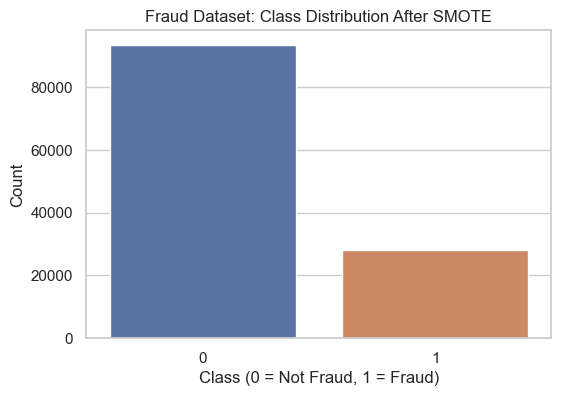

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# === 1. Class distribution after SMOTE (Fraud dataset) ===
plt.figure(figsize=(6,4))
sns.countplot(x=y_fraud_train_balanced)
plt.title("Fraud Dataset: Class Distribution After SMOTE")
plt.xlabel("Class (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

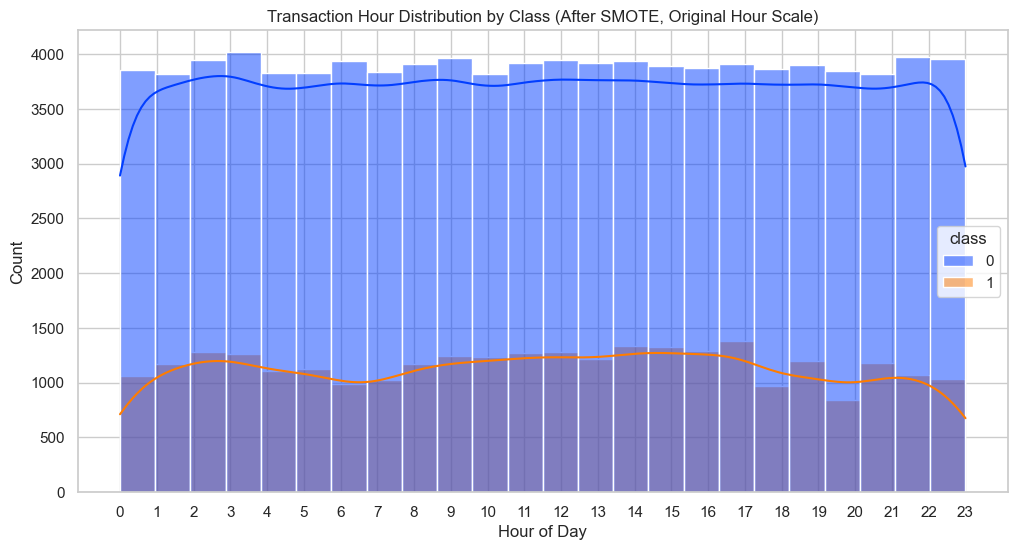

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Inverse transform the scaled hour_of_day
X_fraud_train_balanced_df = pd.DataFrame(X_fraud_train_balanced, columns=X_fraud_train.columns)

# Inverse transform using the original scaler
X_fraud_train_balanced_df['hour_of_day'] = scaler_fraud.inverse_transform(X_fraud_train_balanced_df)[:, X_fraud_train.columns.get_loc('hour_of_day')]

# Add the labels back for plotting
X_fraud_train_balanced_df['class'] = y_fraud_train_balanced.values

# Plot using the original hour range (0–23)
plt.figure(figsize=(12, 6))
sns.histplot(
    data=X_fraud_train_balanced_df,
    x='hour_of_day',
    hue='class',
    kde=True,
    bins=24,
    multiple='layer',
    palette='bright'
)

plt.title("Transaction Hour Distribution by Class (After SMOTE, Original Hour Scale)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


 SAVE PROCESSED DATA

In [26]:
# Convert scaled arrays back to DataFrames for easy handling
X_fraud_train_df = pd.DataFrame(X_fraud_train_balanced, columns=encoded_features)
X_fraud_test_df = pd.DataFrame(X_fraud_test_scaled, columns=encoded_features)

# Save fraud data
print("Saving processed fraud data...")
np.save('X_fraud_train_balanced.npy', X_fraud_train_balanced)
np.save('y_fraud_train_balanced.npy', y_fraud_train_balanced)
np.save('X_fraud_test_scaled.npy', X_fraud_test_scaled)
np.save('y_fraud_test.npy', y_fraud_test)

# Save credit card data
print("Saving processed credit card data...")
np.save('X_cc_train_balanced.npy', X_cc_train_balanced)
np.save('y_cc_train_balanced.npy', y_cc_train_balanced)
np.save('X_cc_test_scaled.npy', X_cc_test_scaled)
np.save('y_cc_test.npy', y_cc_test)

# Save feature names and scalers for later use
import joblib
joblib.dump(scaler_fraud, 'scaler_fraud.pkl')
joblib.dump(scaler_cc, 'scaler_creditcard.pkl')

# Save feature names
with open('fraud_feature_names.txt', 'w') as f:
    for feature in encoded_features:
        f.write(f"{feature}\n")

print("Data transformation completed!")
print("\nFiles saved:")
print("  - X_fraud_train_balanced.npy")
print("  - y_fraud_train_balanced.npy") 
print("  - X_fraud_test_scaled.npy")
print("  - y_fraud_test.npy")
print("  - X_cc_train_balanced.npy")
print("  - y_cc_train_balanced.npy")
print("  - X_cc_test_scaled.npy") 
print("  - y_cc_test.npy")
print("  - scaler_fraud.pkl")
print("  - scaler_creditcard.pkl")
print("  - fraud_feature_names.txt")

Saving processed fraud data...
Saving processed credit card data...
Data transformation completed!

Files saved:
  - X_fraud_train_balanced.npy
  - y_fraud_train_balanced.npy
  - X_fraud_test_scaled.npy
  - y_fraud_test.npy
  - X_cc_train_balanced.npy
  - y_cc_train_balanced.npy
  - X_cc_test_scaled.npy
  - y_cc_test.npy
  - scaler_fraud.pkl
  - scaler_creditcard.pkl
  - fraud_feature_names.txt


SUMMARY STATISTICS

In [27]:
# Display final dataset shapes and class distributions
print("Final dataset shapes:")
print(f"Fraud - Train: {X_fraud_train_balanced.shape}, Test: {X_fraud_test_scaled.shape}")
print(f"Credit Card - Train: {X_cc_train_balanced.shape}, Test: {X_cc_test_scaled.shape}")

print("\nClass distribution after balancing:")
print(f"Fraud train: Normal={Counter(y_fraud_train_balanced)[0]}, Fraud={Counter(y_fraud_train_balanced)[1]}")
print(f"Credit Card train: Normal={Counter(y_cc_train_balanced)[0]}, Fraud={Counter(y_cc_train_balanced)[1]}")

print("\n✅ Data transformation pipeline completed successfully!")
print("Ready for model building and training.")


Final dataset shapes:
Fraud - Train: (121552, 36), Test: (25830, 36)
Credit Card - Train: (294582, 30), Test: (56746, 30)

Class distribution after balancing:
Fraud train: Normal=93502, Fraud=28050
Credit Card train: Normal=226602, Fraud=67980

✅ Data transformation pipeline completed successfully!
Ready for model building and training.


###  SMOTE Balancing & Feature Engineering Summary

####  Purpose
To address extreme class imbalance and improve fraud detection, especially **reducing false negatives** that pose major financial risks.

####  Approach
- Balanced training sets using **SMOTE (30%)** for both datasets.
- Encoded key categorical variables: `country_binned`, `browser`, `age_group`, etc.
- Enhanced features with domain-informed engineering:
  - `hour_of_day` & `purchase_value_category` → binned
  - `is_night_purchase`, `is_peak_hour`, `is_business_day`, `day_part` → time-based signals
  - `device_transaction_count_normalized`, `is_device_1` → flag suspicious device usage
- Dropped low-impact or redundant features like `user_transaction_count`.

####  Key Findings
- **Fraud Rate (Train)**:  
  - Fraud dataset: **9.5%**  
  - Credit card dataset: **0.17%**
- **Post-SMOTE Class Balance**:  
  - Fraud: **0: 93,502 | 1: 28,050**  
  - Credit card: **0: 226,602 | 1: 67,980**

####  Business Impact
- **Device 1** alone handled **~87% of all transactions**, indicating high fraud risk.
- Time-based signals like **night purchases** and **peak hours** now help identify hidden patterns.
- These engineered features are expected to reduce **False Negatives** (e.g., 46 missed fraud cases = ~$133K potential loss).

 Data transformation complete — model training and SHAP validation ready.
